### Problem Statement and Hypothesis
- Research Question: Can the business predict opportunity outcomes?
- Alternate Hypothesis: Yes, we can predict opportunity outcomes
- Null Hypothesis: No, we cannot predict opportunity outcomes

### Recap from Losistic Regression
- Create a dataset where there are equal wins and losses (win rate = 50%)
- Other models should be used to see if there is a better fit, such as KNN, neural networks, decision trees, etc...
- Logistic Regression Metrics:
    - Accuracy: 61%
    - ROC Curve: .66

## Load the data
- This is the preprocessing code from the Logistic Regression notebook 
    - Connecting to the database
    - Cleaning the data
    - Removing outliers by scaling the data
    - Visualizing the data

In [1165]:
#import packages
import pyodbc as db
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

#connect to DB
server = 'tcp:usaepwvds025.database.windows.net' 
database = 'SIMS' 
username = 'ciaserviceaccount' 
password = 'pipeline$330' 
cnxn = db.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)

#load dataframe
sql = "select * from sims.logisticRegression"
df = pd.read_sql(sql,cnxn)

df = df.drop(columns=['LegacyAccountID', 'CurrentCompanyID', 'OpportunityID'])

df = df.drop(columns = 'CloseComments')

df = df.drop(columns = 'StartDate')

df.query('LegacyAccountName != LegacyAccountName')

df.dropna(subset=['LegacyAccountName'], inplace=True)

modeMarketCap = df['CurrentCompanyMarketCapCategory'].mode()
df['CurrentCompanyMarketCapCategory'].fillna(df['CurrentCompanyMarketCapCategory'].mode()[0], inplace=True)

meanMarketCap = df.groupby('CurrentCompanyMarketCapCategory')['CurrentCompanyMarketCap'].mean().reset_index()
totalMeanMarketCap = df['CurrentCompanyMarketCap'].mean()

df['CurrentCompanyMarketCap'] = df['CurrentCompanyMarketCap'].fillna(df.groupby('CurrentCompanyMarketCapCategory')['CurrentCompanyMarketCap'].transform('mean'))

df['CurrentCompanyMarketCap'].fillna(totalMeanMarketCap, inplace = True)

df['Top12CMMCompany'].fillna('False', inplace = True)
df['Top24CMMCompany'].fillna('False', inplace = True)

avgTotalOppAmt = df['TotalOpportunityAmount'].mean()

df['TotalOpportunityAmount'].fillna(avgTotalOppAmt, inplace = True)

CloseReasonMode = df['CloseReason'].mode()

df.loc[(df['CloseReason'].isna()) & (df['StageName'] == "Closed Lost"), 'CloseReason'] = "CloseReasonMode"

df.loc[(df['CloseReason'].isna()) & (df['StageName'] == "Closed Won"), 'CloseReason'] = "Won"

df['CreateDateMonth'] = df['CreateDate'].dt.month 

In [1166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27578 entries, 0 to 27593
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   LegacySFInstance                 27578 non-null  object        
 1   LegacyAccountName                27578 non-null  object        
 2   CurrentCompanyGroup              27578 non-null  object        
 3   CurrentCompanyMarketCap          27578 non-null  float64       
 4   CurrentCompanyMarketCapCategory  27578 non-null  object        
 5   Top12CMMCompany                  27578 non-null  object        
 6   Top24CMMCompany                  27578 non-null  object        
 7   OpportunityName                  27578 non-null  object        
 8   OpportunityType                  27578 non-null  object        
 9   TotalOpportunityAmount           27578 non-null  float64       
 10  CreateDate                       27578 non-null  datetime64[ns]

## Resample the dataset
- Randomly sample the win records to match the number of loss records

In [1167]:
df['StageName'] = df['StageName'].map({'Closed Won': 1, 'Closed Lost': 0})

winRate = (sum(df['StageName'])/len(df['StageName'].index))*100
print(winRate)

55.93589092755094


In [1168]:
winDF = df.query('StageName == True')

In [1169]:
winDF.shape

(15426, 16)

In [1170]:
lossDF = df.query('StageName == False')
lossDF.shape

(12152, 16)

In [1171]:
nrows = lossDF.shape[0]
print(nrows)

12152


In [1172]:
winDF = winDF.sample(n=nrows, random_state = 1)

In [1173]:
newDF = pd.concat([winDF, lossDF], ignore_index = False)

In [1174]:
newDF

,LegacySFInstance,LegacyAccountName,CurrentCompanyGroup,CurrentCompanyMarketCap,CurrentCompanyMarketCapCategory,Top12CMMCompany,Top24CMMCompany,OpportunityName,OpportunityType,TotalOpportunityAmount,CreateDate,OpportunityOwner,StageName,CloseReason,ImpactedFY,CreateDateMonth
3203,RHP,Boehringer Ingelheim,Boehringer Ingelheim,1.361076e+11,Private,YES,False,BI_eV_2021 1st Amnd for Jentadueto,Renewal,0.000000,2021-03-31 21:19:59,Laura Redman,1,Won,FY 2022,3
14743,RxC,"Seattle Genetics, Inc.",Pfizer,1.569656e+11,Large,YES,False,2019 Meeting Exhibits,New,125000.000000,2019-02-19 19:01:52,Heather Krom,1,Won,FY 2019,2
25519,RHP,Viatris,Viatris,1.396581e+10,Large,False,False,Mylan - eVNTT - Effexor XR FY23 Renewal,Renewal,86640.000000,2022-04-06 21:07:20,Scott Hughes,1,Won,FY 2023,4
15202,RHP,Bausch Health,Bausch Health Companies,3.427564e+09,Medium,YES,False,Valeant - DC - Parameter Change & Add NDC,Renewal,753295.921762,2012-10-16 16:05:55,Tom Luby,1,Won,FY 2013,10
7603,CMM,Novartis,Novartis,1.960637e+11,Large,YES,False,Novartis Gleevec PA Partner,New,313850.000000,2015-07-20 14:11:31,Josh Lobs,1,Won,FY 2016,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27579,CMM,Otter Pharmaceuticals,Otter Pharmaceuticals,1.361076e+11,Not Available,False,False,Otter Sympazan HubExpress Renewal 2023-10,Renewal,94484.000000,2023-01-30 15:50:04,David Schneider,0,Price,FY 2024,1
27581,CMM,Otter Pharmaceuticals,Otter Pharmaceuticals,1.361076e+11,Not Available,False,False,Otter Sympazan Prior Authorization Plus Renewa...,Renewal,93713.000000,2023-07-25 19:55:48,Catherine Buchanan,0,Price,FY 2024,7
27582,RxC,Omeza,Omeza,1.361076e+11,Not Available,False,False,Omeza Collagen Matrix Hub RFP,New,732794.000000,2023-03-21 17:50:15,Aimee Crawley,0,Pricing,FY 2024,3
27588,RHP,Biocon Biologics Inc.,Biocon Biologics Inc.,1.361076e+11,Not Available,False,False,"Biocon Biologics_State Insulin Prog (MN, CO, M...",New,0.000000,2024-01-15 17:36:03,Laura Redman,0,No Bid,FY 2024,1


In [1175]:
winRate = (sum(newDF['StageName'])/len(newDF['StageName'].index))*100
print(winRate)

50.0


## Data Visualization and Dummy Variables
- Same code as Logistic Regression notebook 

In [1176]:
pd.crosstab(newDF['ImpactedFY'],newDF['StageName'])

StageName,0,1
ImpactedFY,,
FY 1999,549,0
FY 2005,2,0
FY 2007,0,13
FY 2008,49,222
FY 2009,122,114
FY 2010,212,171
FY 2011,315,187
FY 2012,273,388
FY 2013,468,380


<Axes: title={'center': 'Stage Name vs Impacted Fiscal Year'}, xlabel='ImpactedFY'>

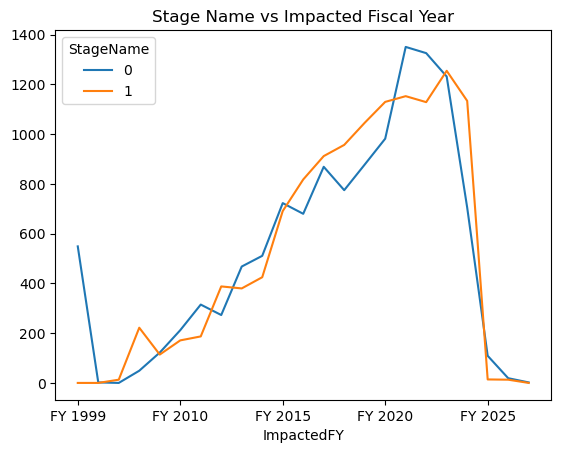

In [1177]:
pd.crosstab(newDF['ImpactedFY'],newDF['StageName']).plot(kind='line', title = 'Stage Name vs Impacted Fiscal Year')

<Axes: title={'center': 'Stage Name vs Create Date Month'}, xlabel='CreateDateMonth'>

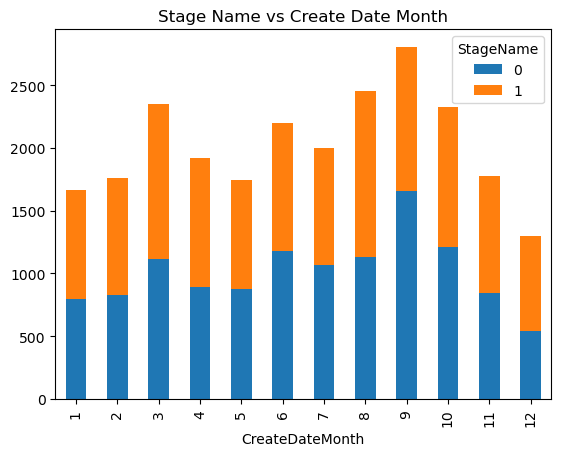

In [1178]:
pd.crosstab(newDF['CreateDateMonth'],newDF['StageName']).plot(kind='bar', stacked = True, title = 'Stage Name vs Create Date Month')

<Axes: title={'center': 'Total Wins by Create Date'}, xlabel='CreateDate'>

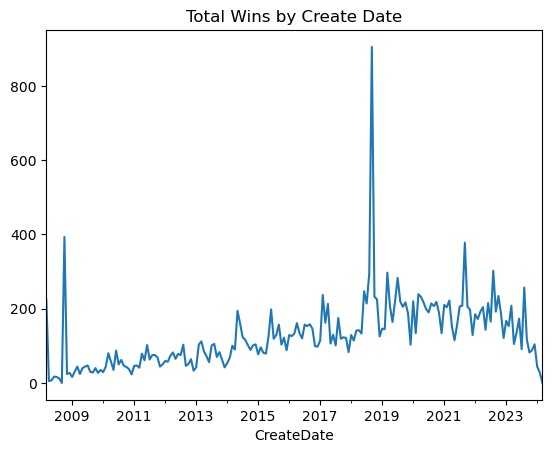

In [1179]:
newDF.set_index('CreateDate', inplace = True)
newDF.resample('1M').count()['StageName'].plot(title = 'Total Wins by Create Date')

<Axes: title={'center': 'Stage Name by Legacy SF Instance'}, xlabel='LegacySFInstance'>

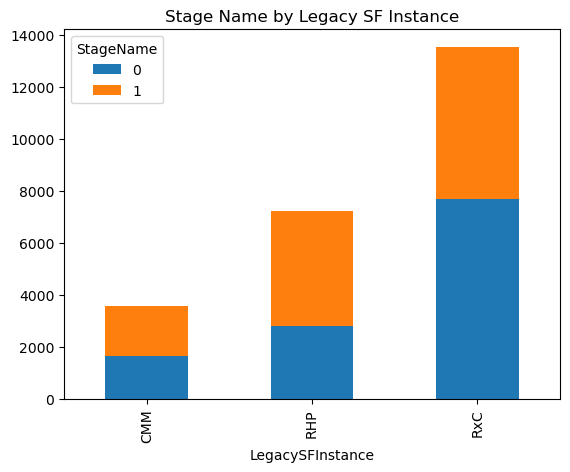

In [1180]:
pd.crosstab(newDF['LegacySFInstance'],newDF['StageName']).plot(kind="bar", stacked=True, title = "Stage Name by Legacy SF Instance")

<Axes: title={'center': 'Stage Name by Market Cap Category'}, xlabel='CurrentCompanyMarketCapCategory'>

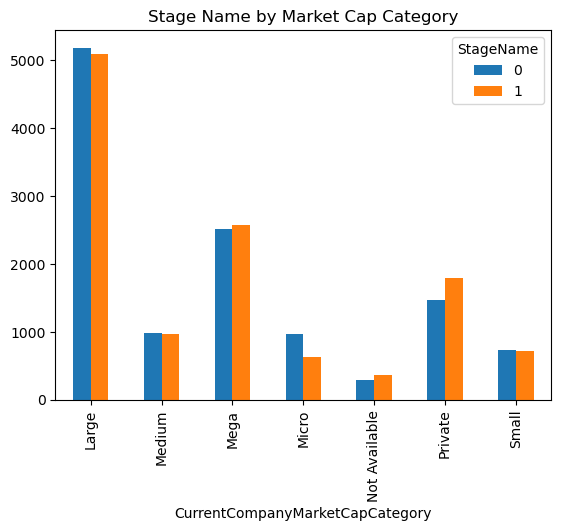

In [1181]:
pd.crosstab(newDF['CurrentCompanyMarketCapCategory'],newDF['StageName']).plot(kind="bar", stacked=False, title="Stage Name by Market Cap Category")

In [1182]:
newDF.reset_index('CreateDate', inplace= True)

In [1183]:
newDF = newDF.drop(columns=['LegacyAccountName', 'CurrentCompanyGroup', 'OpportunityName', 'OpportunityOwner', 'CloseReason', 'CreateDate', 'ImpactedFY'])

In [1184]:
newDF = pd.get_dummies(newDF, columns=["LegacySFInstance", "CurrentCompanyMarketCapCategory", "Top12CMMCompany", "Top24CMMCompany", "OpportunityType", "CreateDateMonth"], prefix=["LegacySFInstance", "CurrentCompanyMarketCapCategory", "Top12CMMCompany", "Top24CMMCompany", "OpportunityType", "CreateDateMonth"], drop_first = True)     

In [1185]:
newDF.head()

,CurrentCompanyMarketCap,TotalOpportunityAmount,StageName,LegacySFInstance_RHP,LegacySFInstance_RxC,CurrentCompanyMarketCapCategory_Medium,CurrentCompanyMarketCapCategory_Mega,CurrentCompanyMarketCapCategory_Micro,CurrentCompanyMarketCapCategory_Not Available,CurrentCompanyMarketCapCategory_Private,...,CreateDateMonth_3,CreateDateMonth_4,CreateDateMonth_5,CreateDateMonth_6,CreateDateMonth_7,CreateDateMonth_8,CreateDateMonth_9,CreateDateMonth_10,CreateDateMonth_11,CreateDateMonth_12
0,1.361076e+11,0.000000,1,True,False,False,False,False,False,True,...,True,False,False,False,False,False,False,False,False,False
1,1.569656e+11,125000.000000,1,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1.396581e+10,86640.000000,1,True,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,3.427564e+09,753295.921762,1,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,1.960637e+11,313850.000000,1,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [1211]:
newDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24304 entries, 0 to 24303
Data columns (total 26 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   CurrentCompanyMarketCap                        24304 non-null  float64
 1   TotalOpportunityAmount                         24304 non-null  float64
 2   StageName                                      24304 non-null  int64  
 3   LegacySFInstance_RHP                           24304 non-null  int64  
 4   LegacySFInstance_RxC                           24304 non-null  int64  
 5   CurrentCompanyMarketCapCategory_Medium         24304 non-null  int64  
 6   CurrentCompanyMarketCapCategory_Mega           24304 non-null  int64  
 7   CurrentCompanyMarketCapCategory_Micro          24304 non-null  int64  
 8   CurrentCompanyMarketCapCategory_Not Available  24304 non-null  int64  
 9   CurrentCompanyMarketCapCategory_Private        243

In [1187]:
newDF = newDF.replace({True: 1, False: 0})

In [1188]:
import seaborn as sb
import statsmodels.api as sm

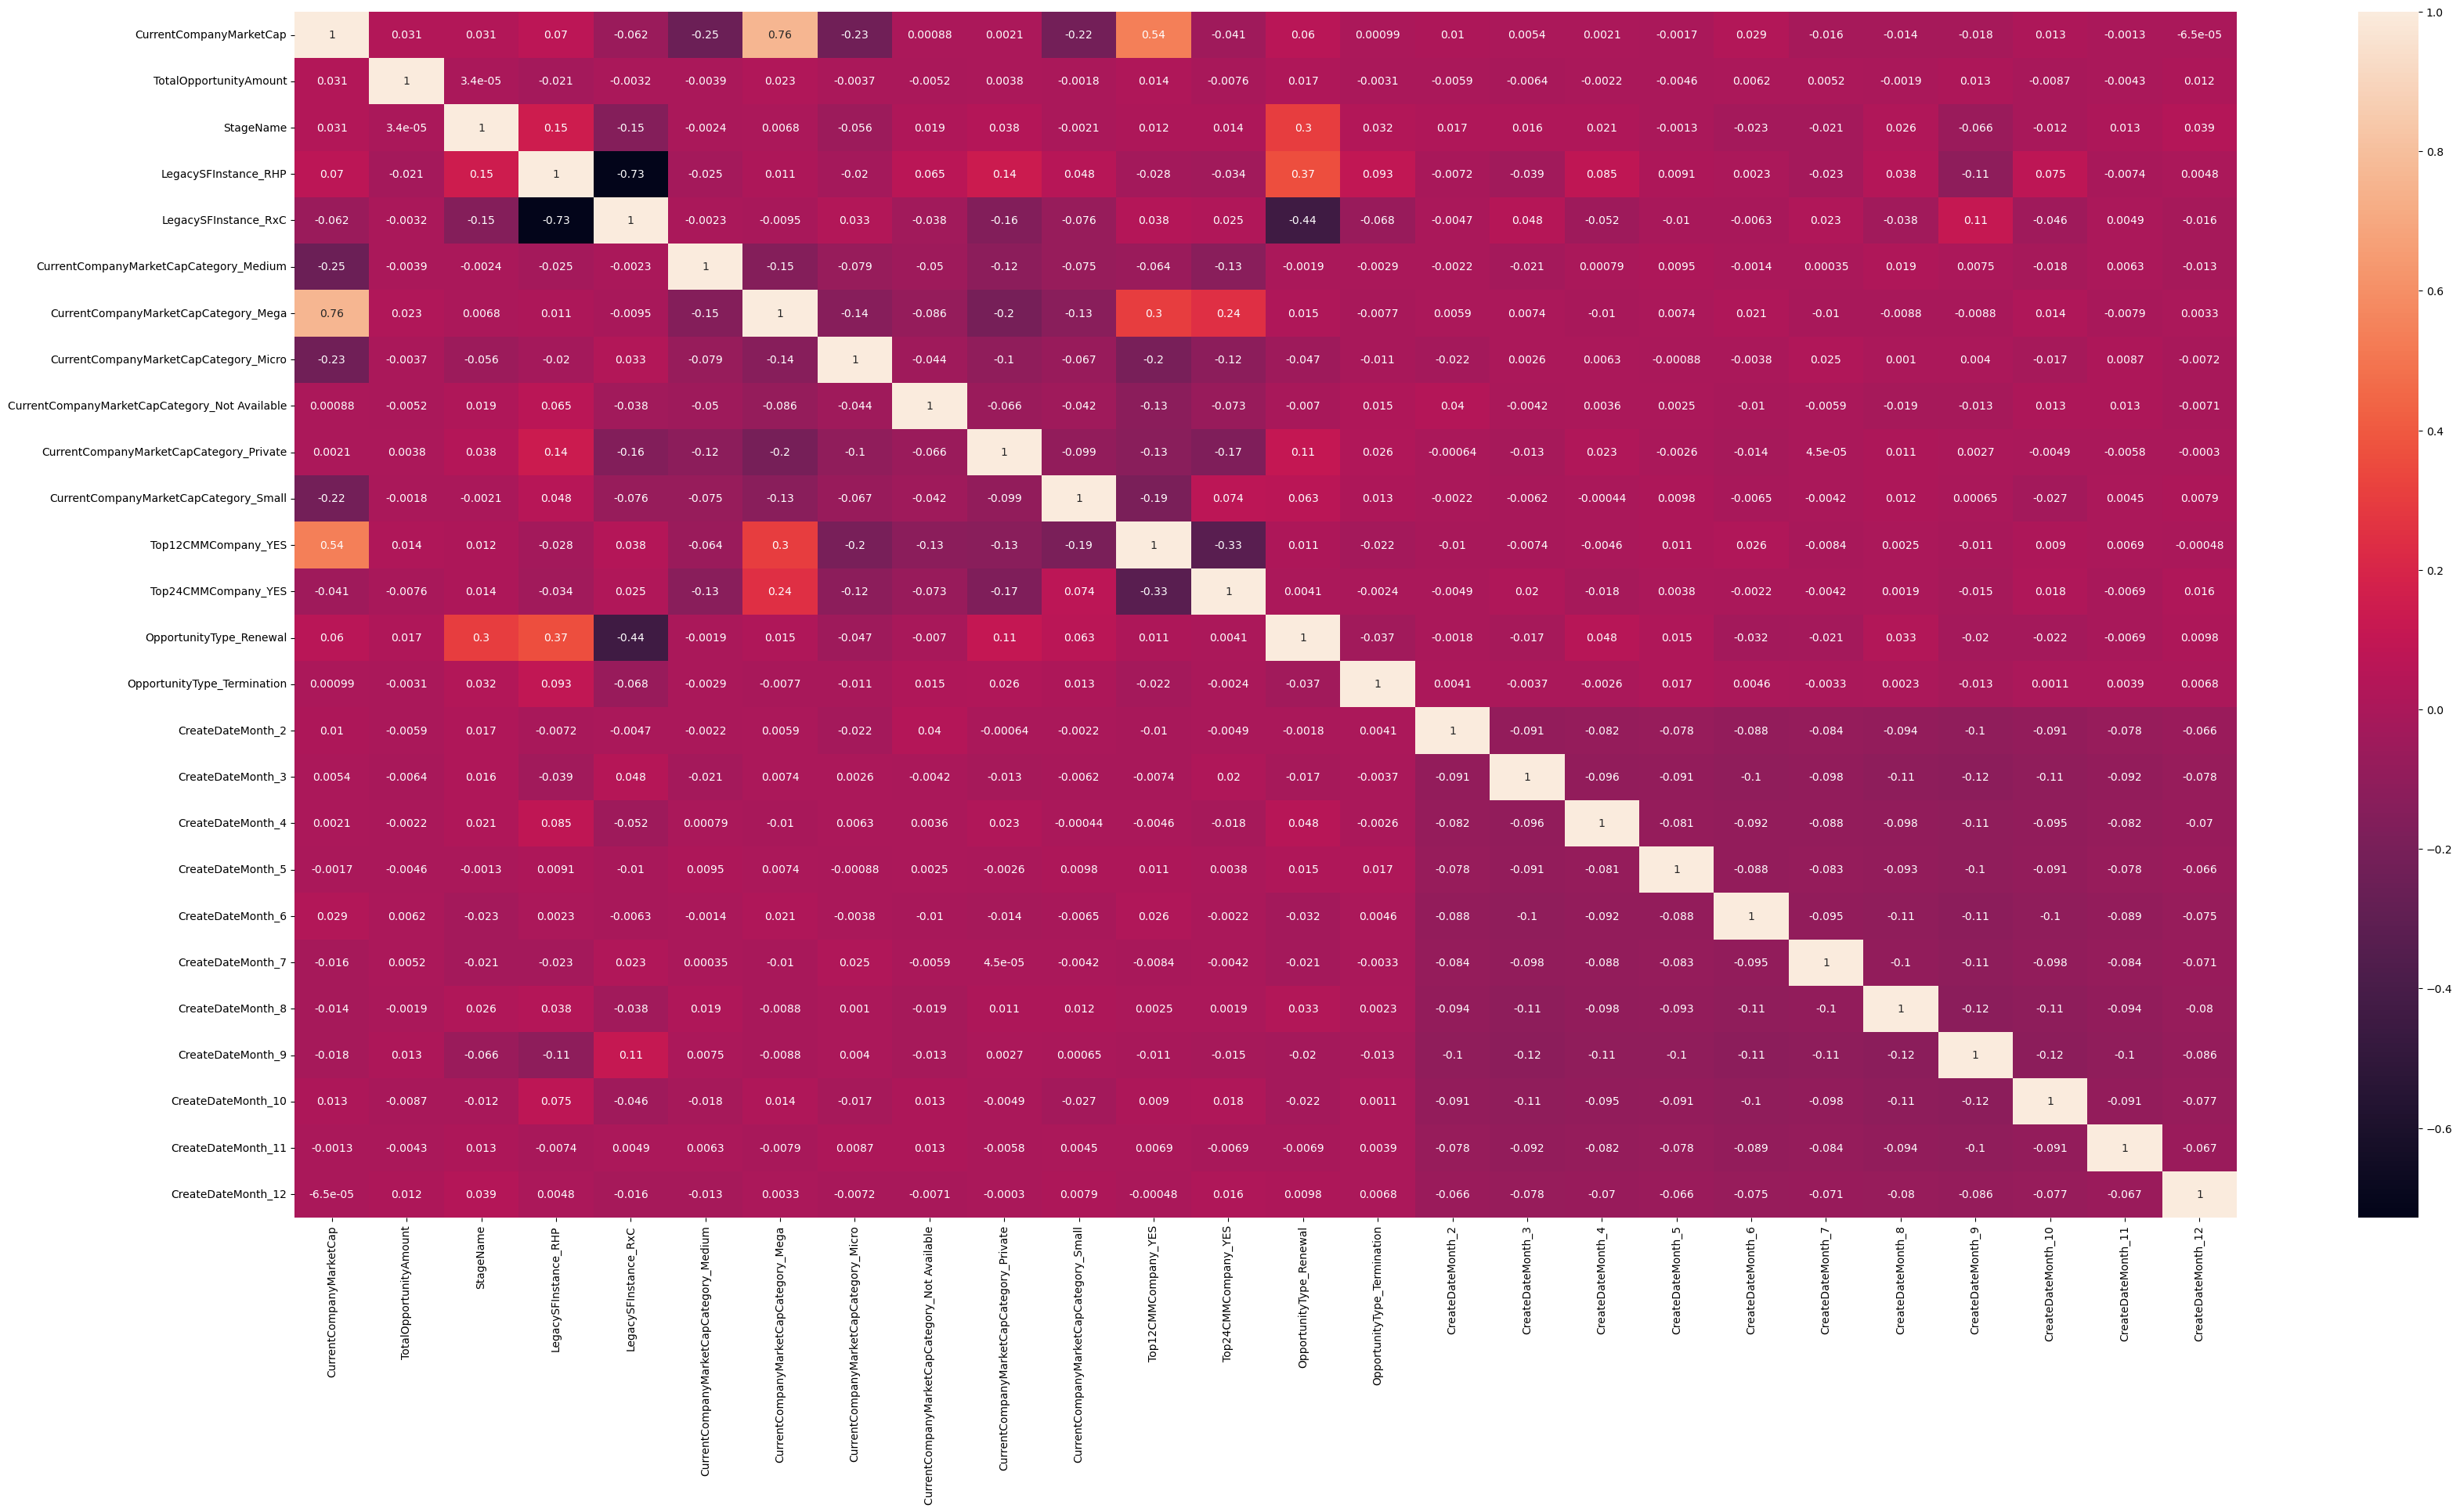

In [1189]:
import matplotlib.pyplot as plt
plt.figure(figsize = (40,20))
sb.heatmap(newDF.corr(), annot = True)
plt.show()

In [1190]:
X = newDF.drop(['StageName', 'Top12CMMCompany_YES'], axis=1)
y = newDF['StageName']

## Split the Dataset

In [1191]:
from sklearn.model_selection import train_test_split #split train and test set
from sklearn.preprocessing import MinMaxScaler #scale features
import numpy as np

In [1192]:
######split data
#split the training and testing sets
 
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

## Scale the Data

In [1193]:
scaler = MinMaxScaler()
X_train_array = scaler.fit_transform(X_train)
X_train_array

array([[9.69431787e-03, 2.37081858e-03, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.91475581e-02, 2.35067082e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 2.88228072e-03, 1.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.18109067e-01, 3.15492150e-03, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.46073570e-04, 2.35721828e-03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.24430062e-01, 3.29197059e-03, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [1194]:
X_train = pd.DataFrame(X_train_array, columns=X_train.columns, index=X_train.index)

In [1195]:
X_test_array = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_array, columns=X_test.columns, index=X_test.index)
X_test.head()

,CurrentCompanyMarketCap,TotalOpportunityAmount,LegacySFInstance_RHP,LegacySFInstance_RxC,CurrentCompanyMarketCapCategory_Medium,CurrentCompanyMarketCapCategory_Mega,CurrentCompanyMarketCapCategory_Micro,CurrentCompanyMarketCapCategory_Not Available,CurrentCompanyMarketCapCategory_Private,CurrentCompanyMarketCapCategory_Small,...,CreateDateMonth_3,CreateDateMonth_4,CreateDateMonth_5,CreateDateMonth_6,CreateDateMonth_7,CreateDateMonth_8,CreateDateMonth_9,CreateDateMonth_10,CreateDateMonth_11,CreateDateMonth_12
1620,0.216608,0.002625,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21995,0.000754,0.002519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6721,0.435102,0.002451,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17797,0.118109,0.002502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7260,1.000000,0.002526,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1196]:
import statsmodels.api as sm #logistic regression with summary
from sklearn.linear_model import LogisticRegression # logistic regression with RFE
from sklearn.feature_selection import RFE #recursive feature elimination
from statsmodels.stats.outliers_influence import variance_inflation_factor #variable selection

newX = sm.add_constant(X_train)
newX.head()

lm = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
lm.fit().summary()

# Use the sklearn logistic regression model for RFE and VIF features
 
##instantiate logistic regression model
lr = LogisticRegression()
rfe = RFE(estimator=lr, n_features_to_select=10)
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns, rfe.support_, rfe.ranking_))



[('CurrentCompanyMarketCap', False, 3),
 ('TotalOpportunityAmount', True, 1),
 ('LegacySFInstance_RHP', True, 1),
 ('LegacySFInstance_RxC', False, 11),
 ('CurrentCompanyMarketCapCategory_Medium', False, 12),
 ('CurrentCompanyMarketCapCategory_Mega', False, 4),
 ('CurrentCompanyMarketCapCategory_Micro', True, 1),
 ('CurrentCompanyMarketCapCategory_Not Available', False, 8),
 ('CurrentCompanyMarketCapCategory_Private', False, 14),
 ('CurrentCompanyMarketCapCategory_Small', True, 1),
 ('Top24CMMCompany_YES', False, 7),
 ('OpportunityType_Renewal', True, 1),
 ('OpportunityType_Termination', True, 1),
 ('CreateDateMonth_2', False, 2),
 ('CreateDateMonth_3', True, 1),
 ('CreateDateMonth_4', False, 13),
 ('CreateDateMonth_5', False, 9),
 ('CreateDateMonth_6', False, 6),
 ('CreateDateMonth_7', False, 5),
 ('CreateDateMonth_8', True, 1),
 ('CreateDateMonth_9', True, 1),
 ('CreateDateMonth_10', False, 10),
 ('CreateDateMonth_11', False, 15),
 ('CreateDateMonth_12', True, 1)]

In [1212]:
lm.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              StageName   No. Observations:                17012
Model:                            GLM   Df Residuals:                    17002
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10902.
Date:                Fri, 22 Mar 2024   Deviance:                       21804.
Time:                        15:19:42   Pearson chi2:                 1.70e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09932
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.4104      0.024    -16.830      0.000      -0.458      -0.363
LegacySFInstance_RHP                      0.1979      0.039      5.136      0.000       0.122       0.273
CurrentCompanyMarketCapCategory_Micro    -0.3106      0.065     -4.765      0.000      -0.438      -0.183
CurrentCompanyMarketCapCategory_Small    -0.2465      0.070     -3.522      0.000      -0.384      -0.109
OpportunityType_Renewal                   1.3876      0.041     33.939      0.000       1.307       1.468
OpportunityType_Termination               1.3513      0.300      4.497      0.000       0.762       1.940
CreateDateMonth_3                         0.2094      0.056      3.730      0.000       0.099       0.319
CreateDateMonth_8                         0.1702      0.055      3.098      0.002       0.063       0.278
CreateDateMonth_9                        -0.3184      0.053     -6.018      0.000      -0.422      -0.215
CreateDateMonth_12                        0.3514      0.072      4.854      0.000       0.210       0.493
=========================================================================================================
"""

In [1197]:
col = X_train.columns[rfe.support_]
col

Index(['TotalOpportunityAmount', 'LegacySFInstance_RHP',
       'CurrentCompanyMarketCapCategory_Micro',
       'CurrentCompanyMarketCapCategory_Small', 'OpportunityType_Renewal',
       'OpportunityType_Termination', 'CreateDateMonth_3', 'CreateDateMonth_8',
       'CreateDateMonth_9', 'CreateDateMonth_12'],
      dtype='object')

In [1198]:
X_train = sm.add_constant(X_train[col])
X_train

lm = sm.GLM(y_train,X_train, family = sm.families.Binomial())
lm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              StageName   No. Observations:                17012
Model:                            GLM   Df Residuals:                    17001
Model Family:                Binomial   Df Model:                           10
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10902.
Date:                Fri, 22 Mar 2024   Deviance:                       21804.
Time:                        14:56:38   Pearson chi2:                 1.70e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09933
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.4082      0.025    -16.556      0.000      -0.457      -0.360
TotalOpportunityAmount                   -0.7096      1.201     -0.591      0.555      -3.064       1.645
LegacySFInstance_RHP                      0.1973      0.039      5.118      0.000       0.122       0.273
CurrentCompanyMarketCapCategory_Micro    -0.3108      0.065     -4.768      0.000      -0.439      -0.183
CurrentCompanyMarketCapCategory_Small    -0.2467      0.070     -3.525      0.000      -0.384      -0.110
OpportunityType_Renewal                   1.3883      0.041     33.939      0.000       1.308       1.468
OpportunityType_Termination               1.3514      0.300      4.497      0.000       0.762       1.940
CreateDateMonth_3                         0.2092      0.056      3.727      0.000       0.099       0.319
CreateDateMonth_8                         0.1702      0.055      3.098      0.002       0.063       0.278
CreateDateMonth_9                        -0.3180      0.053     -6.011      0.000      -0.422      -0.214
CreateDateMonth_12                        0.3519      0.072      4.862      0.000       0.210       0.494
=========================================================================================================
"""

In [1199]:
X_train = X_train.drop(['TotalOpportunityAmount'], axis =1)
X_test = X_test.drop(['TotalOpportunityAmount'], axis =1)

In [1200]:
lm = sm.GLM(y_train,X_train, family = sm.families.Binomial())
lm.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              StageName   No. Observations:                17012
Model:                            GLM   Df Residuals:                    17002
Model Family:                Binomial   Df Model:                            9
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10902.
Date:                Fri, 22 Mar 2024   Deviance:                       21804.
Time:                        14:56:38   Pearson chi2:                 1.70e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09932
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.4104      0.024    -16.830      0.000      -0.458      -0.363
LegacySFInstance_RHP                      0.1979      0.039      5.136      0.000       0.122       0.273
CurrentCompanyMarketCapCategory_Micro    -0.3106      0.065     -4.765      0.000      -0.438      -0.183
CurrentCompanyMarketCapCategory_Small    -0.2465      0.070     -3.522      0.000      -0.384      -0.109
OpportunityType_Renewal                   1.3876      0.041     33.939      0.000       1.307       1.468
OpportunityType_Termination               1.3513      0.300      4.497      0.000       0.762       1.940
CreateDateMonth_3                         0.2094      0.056      3.730      0.000       0.099       0.319
CreateDateMonth_8                         0.1702      0.055      3.098      0.002       0.063       0.278
CreateDateMonth_9                        -0.3184      0.053     -6.018      0.000      -0.422      -0.215
CreateDateMonth_12                        0.3514      0.072      4.854      0.000       0.210       0.493
=========================================================================================================
"""

In [1201]:
    #VIF
######check VIF for correlation
 
#create a dataframe containing VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
#shape[1] gets the number of columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
 
print(vif) # all under 10-15

                                Features   VIF
0                                  const  2.36
1                   LegacySFInstance_RHP  1.19
4                OpportunityType_Renewal  1.17
8                      CreateDateMonth_9  1.06
6                      CreateDateMonth_3  1.04
7                      CreateDateMonth_8  1.04
9                     CreateDateMonth_12  1.03
2  CurrentCompanyMarketCapCategory_Micro  1.01
3  CurrentCompanyMarketCapCategory_Small  1.01
5            OpportunityType_Termination  1.01


In [1202]:
y_train_predict = lm.fit().predict(X_train)
 
print(y_train_predict)

7311     0.398813
18611    0.325455
11247    0.764067
8569     0.447078
16241    0.398813
           ...   
13123    0.485252
19648    0.374813
9845     0.726548
10799    0.716793
2732     0.447078
Length: 17012, dtype: float64


In [1203]:
y_train_predict2 = pd.DataFrame({'StageName':y_train.values, 'StageNameProbability':y_train_predict})
y_train_predict2['Prediction'] = y_train_predict2.StageNameProbability.map(lambda x: 1 if x > 0.5 else 0)
y_train_predict2.head()

,StageName,StageNameProbability,Prediction
7311,1,0.398813,0
18611,0,0.325455,0
11247,1,0.764067,1
8569,1,0.447078,0
16241,0,0.398813,0


In [1204]:
from sklearn import metrics #model performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score #model performance
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score #Receiver operating characteristic
### confusion matrix to understand how good the model is 
cmatrix = metrics.confusion_matrix(y_train_predict2.StageName, y_train_predict2.Prediction )
print(cmatrix)
TN = cmatrix[0,0] # true negatives
print("True Negatives", TN)
FP = cmatrix[0,1] # false positives
print("False Positives", FP)
FN = cmatrix[1,0] # false negatives
print("False Negatives", FN)
TP = cmatrix[1,1] # true positive 
print("True Positives", TP)

[[7268 1262]
 [4933 3549]]
True Negatives 7268
False Positives 1262
False Negatives 4933
True Positives 3549


In [1205]:
accuracy = metrics.accuracy_score(y_train_predict2.StageName, y_train_predict2.Prediction)
#(TN+TP) / (TP+TN+FP+FN)
print("Accuracy", accuracy) 

# sensitivity = TP / (TP+FN)
sensitivity = metrics.recall_score(y_train_predict2.StageName, y_train_predict2.Prediction)
print("Sensitivity", sensitivity) 
 
specificity = TN/ (TN+FP)
print("Specificity", specificity) 

# precision = TP / (TP+FP)
precision = metrics.precision_score(y_train_predict2.StageName, y_train_predict2.Prediction)
print("Precision", precision) 

Accuracy 0.635845285680696
Sensitivity 0.4184154680499882
Specificity 0.8520515826494724
Precision 0.7376844730825193


In [ ]:
# Accuracy 0.6113864378097426
# Sensitivity 0.5962665509008032
# Specificity 0.6303873431533006
# Precision 0.6696733300828864

In [1206]:
X_train

,const,LegacySFInstance_RHP,CurrentCompanyMarketCapCategory_Micro,CurrentCompanyMarketCapCategory_Small,OpportunityType_Renewal,OpportunityType_Termination,CreateDateMonth_3,CreateDateMonth_8,CreateDateMonth_9,CreateDateMonth_12
7311,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18611,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11247,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8569,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16241,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
13123,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
19648,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9845,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10799,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [1207]:
cols_to_keep = ['LegacySFInstance_RHP', 'CurrentCompanyMarketCapCategory_Micro', 'CurrentCompanyMarketCapCategory_Small', 'OpportunityType_Renewal', 'OpportunityType_Termination', 'CreateDateMonth_5', 'CreateDateMonth_7', 'CreateDateMonth_9', 'CreateDateMonth_12']

X_test = X_test[cols_to_keep]
X_test = sm.add_constant(X_test)


X_test = sm.add_constant(X_test)

y_test_predic = lm.fit().predict(X_test)
y_test_predic

y_test_predic2 = pd.DataFrame({'StageName':y_test.values, 'StageNameProbability':y_test_predic})
y_test_predic2.head()

y_test_predic2['Prediction'] = y_test_predic2.StageNameProbability.map(lambda x: 1 if x > 0.5 else 0)
y_test_predic2.head()

,StageName,StageNameProbability,Prediction
1620,1,0.398813,0
21995,0,0.380670,0
6721,1,0.821496,1
17797,0,0.398813,0
7260,1,0.398813,0


In [1208]:
cmatrix2 = metrics.confusion_matrix(y_test_predic2.StageName, y_test_predic2.Prediction )
print(cmatrix2)
TN2 = cmatrix2[0,0] # true negatives
print("True Negatives", TN2)
FP2 = cmatrix2[0,1] # false positives
print("False Positives", FP2)
FN2 = cmatrix2[1,0] # false negatives
print("False Negatives", FN2)
TP2 = cmatrix2[1,1] # true positive 
print("True Positives", TP2)

[[3108  514]
 [2162 1508]]
True Negatives 3108
False Positives 514
False Negatives 2162
True Positives 1508


In [1209]:
accuracy = metrics.accuracy_score(y_test_predic2.StageName, y_test_predic2.Prediction)
#(TN+TP) / (TP+TN+FP+FN)
print("Accuracy", accuracy) #63.14% train -> 63.64% test
 
sensitivity = TP2 / (TP2+FN2)
print("Sensitivity", sensitivity) #41.83% train -> 42.99% test
 
specificity = TN2/ (TN2+FP2)
print("Specificity", specificity) #84.31% train -> 84.56% test
 
precision = TP2 / (TP2+FP2)
print("Precision", precision) #72.62% -> 73.84% test

Accuracy 0.6330224904004388
Sensitivity 0.4108991825613079
Specificity 0.8580894533406958
Precision 0.7457962413452027


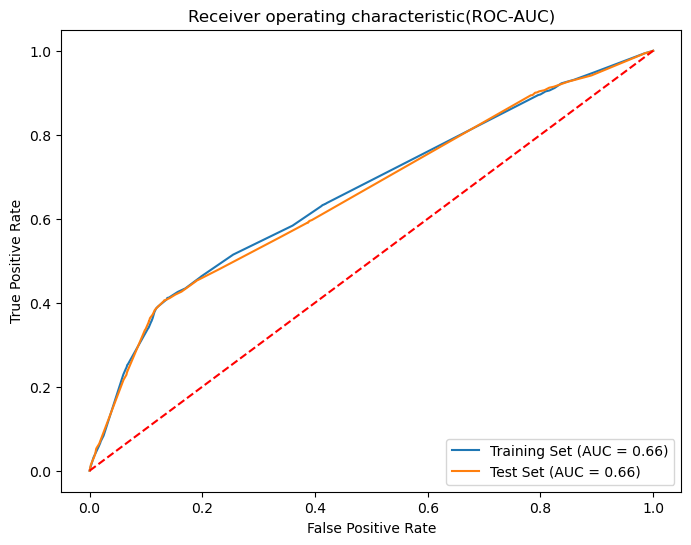

In [1210]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_predict)
roc_auc = roc_auc_score(y_train, y_train_predict)

fpr2, tpr2, thresholds2 = roc_curve(y_test, y_test_predic)
roc_auc2 = roc_auc_score(y_test, y_test_predic)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Training Set (AUC = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2,label='Test Set (AUC = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic(ROC-AUC)')
plt.legend(loc="lower right")
plt.show()

## XGBoost Modeling

- Mainly used for classification and regression modeling
- **Ensemble Learning:** Combines multiple weak prediction models (typically decision trees) to create a robust predictive model

<img src="decisionTree.png" width="500"/>   <img src="Bagging-Ensemble.png" width="400" height="100"/>


## Split and Scale
- Set training and testing variables again
- Scale data to remove outliers

In [1213]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)

In [1214]:
scaler = MinMaxScaler()
X_train_array = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_array, columns=X_train.columns, index=X_train.index)
X_train.head()

,CurrentCompanyMarketCap,TotalOpportunityAmount,LegacySFInstance_RHP,LegacySFInstance_RxC,CurrentCompanyMarketCapCategory_Medium,CurrentCompanyMarketCapCategory_Mega,CurrentCompanyMarketCapCategory_Micro,CurrentCompanyMarketCapCategory_Not Available,CurrentCompanyMarketCapCategory_Private,CurrentCompanyMarketCapCategory_Small,...,CreateDateMonth_3,CreateDateMonth_4,CreateDateMonth_5,CreateDateMonth_6,CreateDateMonth_7,CreateDateMonth_8,CreateDateMonth_9,CreateDateMonth_10,CreateDateMonth_11,CreateDateMonth_12
7311,0.009694,0.002371,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
18611,0.019148,0.002351,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
11247,1.000000,0.002882,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8569,0.187825,0.002351,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
16241,0.020605,0.002376,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [1215]:
X_test_array = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_array, columns=X_test.columns, index=X_test.index)
X_test.head()

,CurrentCompanyMarketCap,TotalOpportunityAmount,LegacySFInstance_RHP,LegacySFInstance_RxC,CurrentCompanyMarketCapCategory_Medium,CurrentCompanyMarketCapCategory_Mega,CurrentCompanyMarketCapCategory_Micro,CurrentCompanyMarketCapCategory_Not Available,CurrentCompanyMarketCapCategory_Private,CurrentCompanyMarketCapCategory_Small,...,CreateDateMonth_3,CreateDateMonth_4,CreateDateMonth_5,CreateDateMonth_6,CreateDateMonth_7,CreateDateMonth_8,CreateDateMonth_9,CreateDateMonth_10,CreateDateMonth_11,CreateDateMonth_12
1620,0.216608,0.002625,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21995,0.000754,0.002519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6721,0.435102,0.002451,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17797,0.118109,0.002502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7260,1.000000,0.002526,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1084]:
import sys
# !{sys.executable} -m pip install xgboost
from xgboost import XGBClassifier
# Create an instance of the XGBClassifier
model = XGBClassifier(objective='binary:logistic')

# Fit the model to the training data
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [1085]:
y_pred = model.predict(X_train)
print(y_pred)

[1 0 1 ... 1 1 1]


In [1086]:
y_pred_proba = model.predict_proba(X_train)
y_pred_proba

array([[0.32947063, 0.67052937],
       [0.9699789 , 0.03002104],
       [0.13966501, 0.860335  ],
       ...,
       [0.01279056, 0.98720944],
       [0.12679243, 0.87320757],
       [0.35246336, 0.64753664]], dtype=float32)

In [1087]:
y_train_predict = pd.DataFrame({'StageName': y_train.values, 'Probabilities': y_pred_proba[:,1], 'StageNameValues': y_pred})
y_train_predict.head()

,StageName,Probabilities,StageNameValues
0,1,0.670529,1
1,0,0.030021,0
2,1,0.860335,1
3,1,0.816405,1
4,0,0.481044,0


In [1088]:
accuracy = model.score(X_train, y_train)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.37%


### Use the test set to view metrics of the model

In [1089]:
y_pred2 = model.predict(X_test)
print(y_pred2)

[1 0 1 ... 0 0 0]


In [1090]:
y_pred_proba2 = model.predict_proba(X_test)
y_pred_proba2

array([[0.39398843, 0.60601157],
       [0.5247814 , 0.4752186 ],
       [0.2334494 , 0.7665506 ],
       ...,
       [0.93804944, 0.06195056],
       [0.93578035, 0.06421966],
       [0.944022  , 0.05597798]], dtype=float32)

In [1091]:
y_test_predict = pd.DataFrame({'StageName':y_test.values, 'Probabilities': y_pred_proba2[:,1], 'StageNameValue': y_pred2})
y_test_predict.head()

,StageName,Probabilities,StageNameValue
0,1,0.606012,1
1,0,0.475219,0
2,1,0.766551,1
3,0,0.389608,0
4,1,0.426508,0


In [1092]:
# Calculate accuracy
accuracy = model.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.79%


## Classification Report

- **Accuracy:** Measures how well the model accurately identifies the samples to their true value
- **Sensitivity/Recall:** Measures how well the model is at detecting true positives
- **Specificity:** Measures how well the model is at avoiding false positives
- **Precision:** Measures the proportion of true positives vs the sum of true positives and false positives
- **F1-Score:** The harmonic mean of precision and recall. It provides a balance between precision and recall. The higher the score, the better the model
- **Support:** Number of samples in each class in the dataset

### Training metrics

In [1093]:
from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      8530
           1       0.81      0.82      0.82      8482

    accuracy                           0.81     17012
   macro avg       0.81      0.81      0.81     17012
weighted avg       0.81      0.81      0.81     17012



In [1094]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)

# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

print("Specificity:", specificity)

Specificity: 0.8041031652989449


In [1095]:
print(conf_matrix)

[[6859 1671]
 [1498 6984]]


### Testing Metrics

In [1096]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.72      0.71      0.72      3622
           1       0.72      0.72      0.72      3670

    accuracy                           0.72      7292
   macro avg       0.72      0.72      0.72      7292
weighted avg       0.72      0.72      0.72      7292



In [1097]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred2)

# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

print("Specificity:", specificity)

Specificity: 0.7147984538928769


### ROC Curve
- Visualizes how well the model predicts `StageName` as opposed to random chance
- The area between the dotted line and the blue line is the 'lift' from random chance
- The total area under the blue curve is the AUC score (AUC of 1 means the model predicts the right outcome 100% of the time)

In [1098]:
from sklearn.metrics import log_loss, roc_auc_score
# Training set
# Calculate log loss
log_loss(y_train, y_pred_proba)

# Calculate ROC AUC
roc_auc_score(y_train, y_pred_proba[:,1])

0.8987689052853943

In [1099]:
from sklearn.metrics import log_loss, roc_auc_score
# Test set
# Calculate log loss
log_loss(y_test, y_pred_proba2)

# Calculate ROC AUC
roc_auc_score(y_test, y_pred_proba2[:,1])

0.7995737899033608

In [1103]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba[:,1])
roc_auc = roc_auc_score(y_train, y_pred_proba[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_proba2[:,1])
roc_auc2 = roc_auc_score(y_test, y_pred_proba2[:,1])

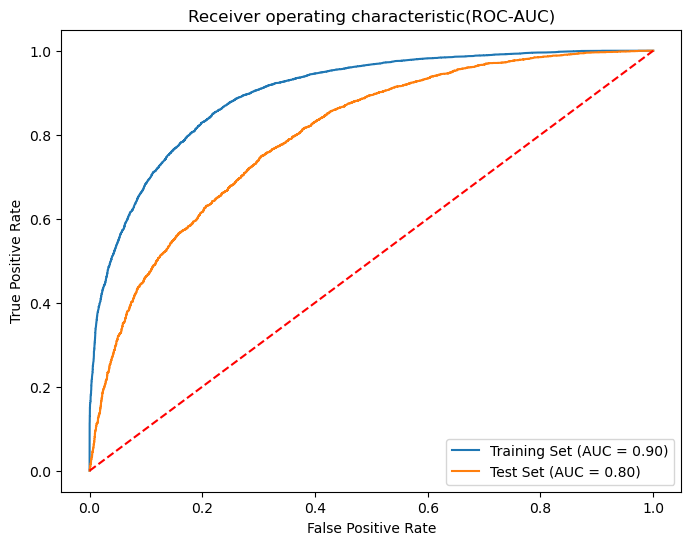

In [1104]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Training Set (AUC = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2,label='Test Set (AUC = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic(ROC-AUC)')
plt.legend(loc="lower right")
plt.show()

### Feature Importance 
- **Gain**: The relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for each tree in the model

In [952]:
model.get_booster().get_score(importance_type="gain")

{'CurrentCompanyMarketCap': 1.8794430494308472,
 'TotalOpportunityAmount': 4.708095073699951,
 'LegacySFInstance_RHP': 3.907252788543701,
 'LegacySFInstance_RxC': 8.321537971496582,
 'CurrentCompanyMarketCapCategory_Medium': 1.6109638214111328,
 'CurrentCompanyMarketCapCategory_Not Available': 2.367870569229126,
 'CurrentCompanyMarketCapCategory_Private': 2.7542343139648438,
 'CurrentCompanyMarketCapCategory_Small': 2.5690112113952637,
 'Top24CMMCompany_YES': 2.5318615436553955,
 'OpportunityType_Renewal': 30.761598587036133,
 'OpportunityType_Termination': 1.8996729850769043,
 'CreateDateMonth_2': 1.848238229751587,
 'CreateDateMonth_3': 2.327394723892212,
 'CreateDateMonth_4': 1.6141806840896606,
 'CreateDateMonth_5': 1.7922030687332153,
 'CreateDateMonth_6': 2.1125833988189697,
 'CreateDateMonth_7': 2.1177098751068115,
 'CreateDateMonth_8': 2.058274030685425,
 'CreateDateMonth_9': 2.5890393257141113,
 'CreateDateMonth_10': 2.6767005920410156,
 'CreateDateMonth_11': 1.998733043670654

## Plotting Feature Importance
- Displays the relevant importance of each feature in the dataset
- Helps determine which features are most influencial in the model prediction
- Based on weight, gain, and cover metrics
    - Weight: Number of times a feature appears in a tree across all trees in the model. 
    - Cover: The sum of the number of observations for each feature across all nodes.
    - Gain: Compares the loss reduction score due to a feature split to the parent's node's loss.

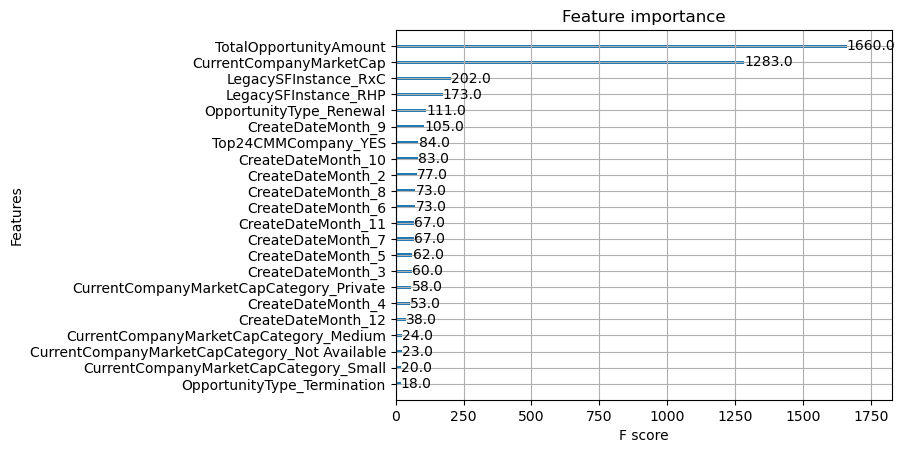

In [953]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

plot_importance(model)
pyplot.show()

In [1216]:
# use feature importance for feature selection
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)

for thresh in thresholds:
	# select features using threshold
    # prefit: Set equal to true when performing feature selection since there is a pre-trained model that is being used
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_test)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_test, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 71.45%
Thresh=0.000, n=24, Accuracy: 71.45%
Thresh=0.000, n=24, Accuracy: 71.45%
Thresh=0.017, n=22, Accuracy: 71.45%
Thresh=0.021, n=21, Accuracy: 71.45%
Thresh=0.022, n=20, Accuracy: 71.50%
Thresh=0.023, n=19, Accuracy: 71.37%
Thresh=0.023, n=18, Accuracy: 71.53%
Thresh=0.024, n=17, Accuracy: 71.12%
Thresh=0.025, n=16, Accuracy: 70.60%
Thresh=0.026, n=15, Accuracy: 70.95%
Thresh=0.026, n=14, Accuracy: 71.22%
Thresh=0.026, n=13, Accuracy: 71.15%
Thresh=0.027, n=12, Accuracy: 70.93%
Thresh=0.027, n=11, Accuracy: 71.19%
Thresh=0.027, n=10, Accuracy: 71.11%
Thresh=0.029, n=9, Accuracy: 71.09%
Thresh=0.029, n=8, Accuracy: 70.90%
Thresh=0.032, n=7, Accuracy: 70.93%
Thresh=0.035, n=6, Accuracy: 70.12%
Thresh=0.044, n=5, Accuracy: 69.97%
Thresh=0.049, n=4, Accuracy: 69.72%
Thresh=0.060, n=3, Accuracy: 69.78%
Thresh=0.107, n=2, Accuracy: 63.21%
Thresh=0.299, n=1, Accuracy: 63.21%


In [955]:
for thresh in thresholds:
	# select features using threshold
	selection = SelectFromModel(model, threshold=thresh, prefit=True)
	select_X_train = selection.transform(X_train)
	# train model
	selection_model = XGBClassifier()
	selection_model.fit(select_X_train, y_train)
	# eval model
	select_X_test = selection.transform(X_test)
	y_pred = selection_model.predict(select_X_train)
	predictions = [round(value) for value in y_pred]
	accuracy = accuracy_score(y_train, predictions)
	print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=24, Accuracy: 81.37%
Thresh=0.000, n=24, Accuracy: 81.37%
Thresh=0.018, n=22, Accuracy: 81.37%
Thresh=0.018, n=21, Accuracy: 81.23%
Thresh=0.020, n=20, Accuracy: 81.14%
Thresh=0.021, n=19, Accuracy: 81.12%
Thresh=0.021, n=18, Accuracy: 80.80%
Thresh=0.022, n=17, Accuracy: 78.33%
Thresh=0.023, n=16, Accuracy: 78.29%
Thresh=0.024, n=15, Accuracy: 78.13%
Thresh=0.024, n=14, Accuracy: 77.70%
Thresh=0.024, n=13, Accuracy: 77.54%
Thresh=0.027, n=12, Accuracy: 77.32%
Thresh=0.027, n=11, Accuracy: 77.03%
Thresh=0.029, n=10, Accuracy: 76.92%
Thresh=0.029, n=9, Accuracy: 76.73%
Thresh=0.030, n=8, Accuracy: 76.22%
Thresh=0.031, n=7, Accuracy: 75.88%
Thresh=0.031, n=6, Accuracy: 75.05%
Thresh=0.034, n=5, Accuracy: 74.38%
Thresh=0.045, n=4, Accuracy: 74.01%
Thresh=0.054, n=3, Accuracy: 73.32%
Thresh=0.095, n=2, Accuracy: 63.48%
Thresh=0.352, n=1, Accuracy: 63.48%


In [1252]:
# select features using threshold
selection = SelectFromModel(model, threshold=.021, prefit=False)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier()
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
y_pred = selection_model.predict(select_X_test)

In [1253]:
kept_features = X_train.columns[selection.get_support()]
kept_features

Index(['CurrentCompanyMarketCap', 'TotalOpportunityAmount',
       'LegacySFInstance_RHP', 'LegacySFInstance_RxC',
       'CurrentCompanyMarketCapCategory_Medium',
       'CurrentCompanyMarketCapCategory_Not Available',
       'CurrentCompanyMarketCapCategory_Private',
       'CurrentCompanyMarketCapCategory_Small', 'Top24CMMCompany_YES',
       'OpportunityType_Renewal', 'OpportunityType_Termination',
       'CreateDateMonth_2', 'CreateDateMonth_3', 'CreateDateMonth_4',
       'CreateDateMonth_6', 'CreateDateMonth_7', 'CreateDateMonth_8',
       'CreateDateMonth_9', 'CreateDateMonth_10', 'CreateDateMonth_11',
       'CreateDateMonth_12'],
      dtype='object')

In [1254]:
# Calculate accuracy
accuracy = selection_model.score(select_X_train, y_train)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 80.94%


In [1255]:
# Calculate accuracy
accuracy = selection_model.score(select_X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.45%


In [1256]:
y_pred = selection_model.predict(select_X_train)

print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81      8530
           1       0.80      0.82      0.81      8482

    accuracy                           0.81     17012
   macro avg       0.81      0.81      0.81     17012
weighted avg       0.81      0.81      0.81     17012



In [1257]:
y_pred2 = selection_model.predict(select_X_test)

print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.71      0.71      0.71      3622
           1       0.72      0.72      0.72      3670

    accuracy                           0.71      7292
   macro avg       0.71      0.71      0.71      7292
weighted avg       0.71      0.71      0.71      7292



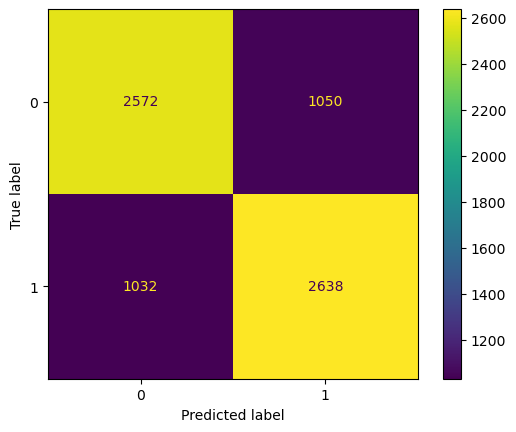

In [1258]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

labels = [1,0]
cm = confusion_matrix(y_test, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [1259]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred2)

# Calculate specificity (True Negative Rate)
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

print("Specificity:", specificity)



Specificity: 0.7101049144119271


In [1260]:
y_pred_prob = selection_model.predict_proba(select_X_train)[:,1]
y_pred_prob2 = selection_model.predict_proba(select_X_test)[:,1]

In [1261]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred_prob)
roc_auc = roc_auc_score(y_train, y_pred)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)
roc_auc2 = roc_auc_score(y_test, y_pred2)

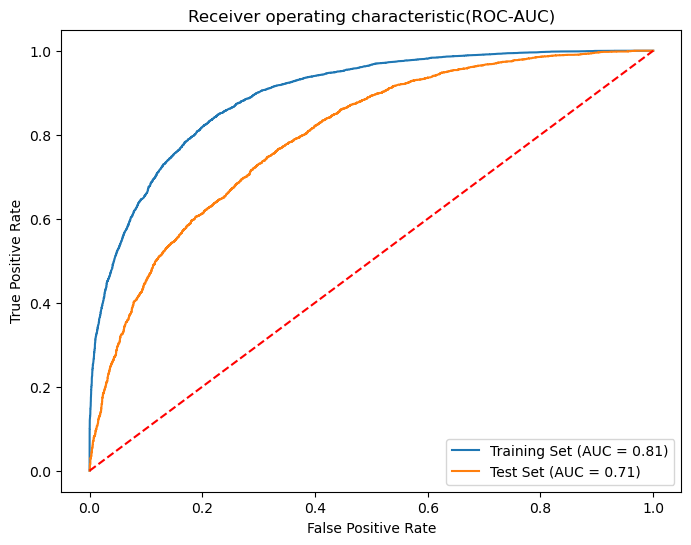

In [1262]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Training Set (AUC = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2,label='Test Set (AUC = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic(ROC-AUC)')
plt.legend(loc="lower right")
plt.show()

### Precision Recall Curve
- Displays the trade off between precision and recall for different values
- Area under the curve: Provides a value summarizing the performance of a binary classification model across possible threshold values. 
    - A higher value indicates better performance

In [1263]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob2)
pr_auc = auc(recall, precision)
pr_auc

0.7827334154315707

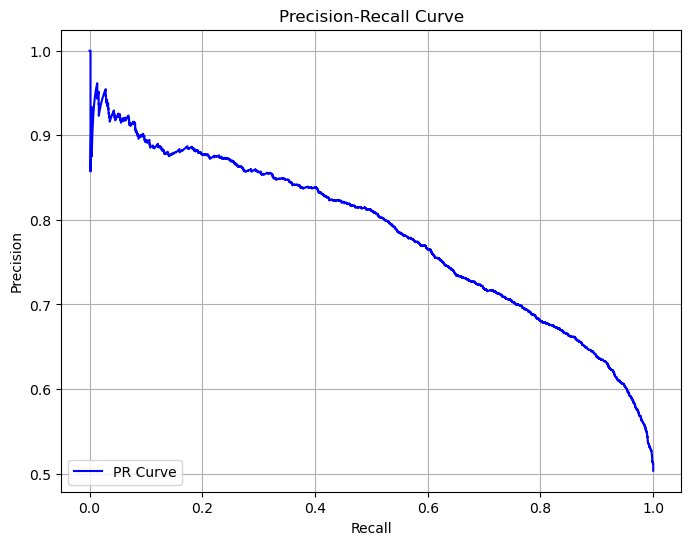

In [1264]:
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color = 'blue', label=f'PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

### Summary
- Acceptable accuracy score: 70-90%
- Acceptable AUC score: 70-90%

We reject the null hypothesis and conclude that there is sufficient evidence to say that we can predict opportunity outcomes. 
The result of the model shows an accuracy, sensitivity, specificity, precision, F1-Score, and AUC values greater than .7

The following features were important in the model:

In [1265]:
kept_features

Index(['CurrentCompanyMarketCap', 'TotalOpportunityAmount',
       'LegacySFInstance_RHP', 'LegacySFInstance_RxC',
       'CurrentCompanyMarketCapCategory_Medium',
       'CurrentCompanyMarketCapCategory_Not Available',
       'CurrentCompanyMarketCapCategory_Private',
       'CurrentCompanyMarketCapCategory_Small', 'Top24CMMCompany_YES',
       'OpportunityType_Renewal', 'OpportunityType_Termination',
       'CreateDateMonth_2', 'CreateDateMonth_3', 'CreateDateMonth_4',
       'CreateDateMonth_6', 'CreateDateMonth_7', 'CreateDateMonth_8',
       'CreateDateMonth_9', 'CreateDateMonth_10', 'CreateDateMonth_11',
       'CreateDateMonth_12'],
      dtype='object')